In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import cupy as cp  # GPU 배열 라이브러리
import matplotlib.pyplot as plt

# 데이터 불러오기
train_data = pd.read_csv('train.csv')  # 학습 데이터
test_data = pd.read_csv('test.csv')    # 테스트 데이터

# 범주형 데이터 인코딩 (학습 데이터)
one_hot_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # One-Hot Encoding 대상 컬럼

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train_data[one_hot_cols]).toarray()
train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=train_data.index)
train_data = pd.concat([train_data.drop(columns=one_hot_cols), train_encoded_df], axis=1)

test_encoded = one_hot_encoder.transform(test_data[one_hot_cols]).toarray()
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test_data.index)
test_data = pd.concat([test_data.drop(columns=one_hot_cols), test_encoded_df], axis=1)


print('train_data.index', train_data.index) # RangeIndex(start=0, stop=2452, step=1)

train_data.index RangeIndex(start=0, stop=2452, step=1)


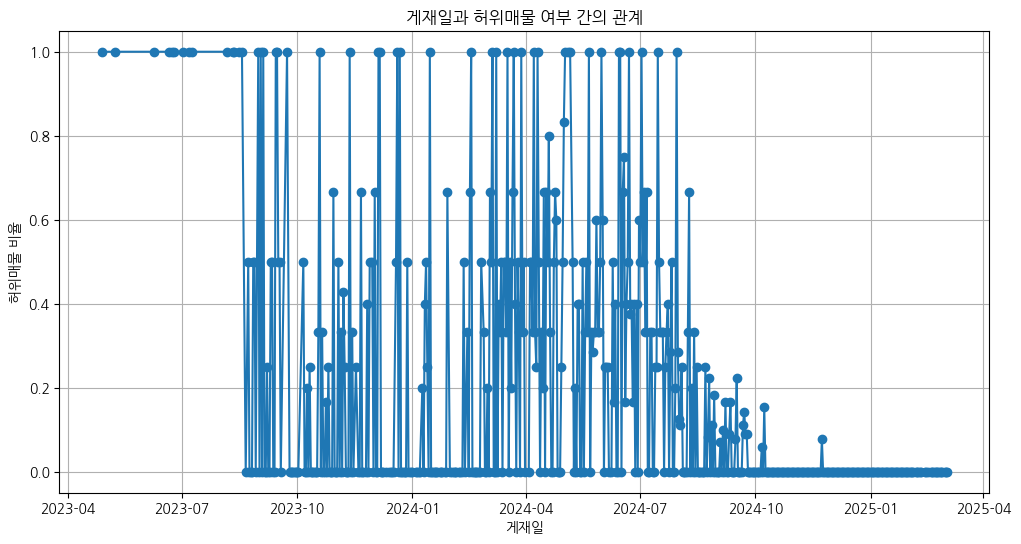

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
train_data = pd.read_csv('train.csv')  # 학습 데이터

# 날짜 데이터 처리
train_data['게재일'] = pd.to_datetime(train_data['게재일'])

# 게재일 기준 허위매물 비율 계산
daily_false_rate = train_data.groupby('게재일')['허위매물여부'].mean()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(daily_false_rate.index, daily_false_rate.values, marker='o')
plt.xlabel('게재일')
plt.ylabel('허위매물 비율')
plt.title('게재일과 허위매물 여부 간의 관계')
plt.grid(True)
plt.show()

In [2]:
print(train_data.keys())

Index(['ID', '보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비',
       ...
       '제공플랫폼_H플랫폼', '제공플랫폼_I플랫폼', '제공플랫폼_J플랫폼', '제공플랫폼_K플랫폼', '제공플랫폼_L플랫폼',
       '제공플랫폼_M플랫폼', '게재연도', '게재월', '게재일자', '게재요일'],
      dtype='object', length=320)


In [3]:
print(max(train_data['관리비']))

96


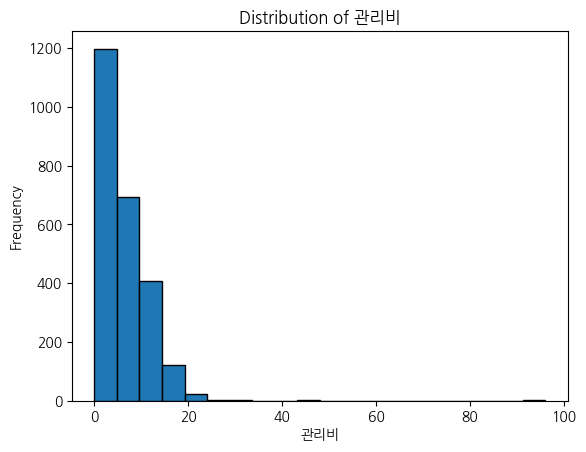

count    2452.000000
mean        5.477977
std         5.631185
min         0.000000
25%         0.000000
50%         5.000000
75%         9.000000
max        96.000000
Name: 관리비, dtype: float64


In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# NanumGothic 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로 확인
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 관리비 히스토그램
plt.hist(train_data['관리비'], bins=20, edgecolor='black')
plt.title('Distribution of 관리비')
plt.xlabel('관리비')
plt.ylabel('Frequency')
plt.show()

print(train_data['관리비'].describe())



In [10]:
# 피처 엔지니어링 (보증금, 월세, 관리비를 활용한 새로운 특성 생성)
train_data['월세_비율'] = train_data['월세'] / train_data['보증금']
train_data['관리비_비율'] = train_data['관리비'] / train_data['보증금']
train_data['층_비율'] = train_data['해당층'] / train_data['총층']
train_data['관리비_구간'] = pd.cut(train_data['관리비'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
train_data['보증금_로그'] = np.log1p(train_data['보증금'])

test_data['월세_비율'] = test_data['월세'] / test_data['보증금']
test_data['관리비_비율'] = test_data['관리비'] / test_data['보증금']
test_data['층_비율'] = test_data['해당층'] / test_data['총층']
test_data['관리비_구간'] = pd.cut(test_data['관리비'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0, 1, 2, 3, 4, 5])
test_data['보증금_로그'] = np.log1p(test_data['보증금'])

In [11]:
print(train_data.keys())

Index(['ID', '보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비',
       ...
       '제공플랫폼_M플랫폼', '게재연도', '게재월', '게재일자', '게재요일', '월세_비율', '관리비_비율', '층_비율',
       '관리비_구간', '보증금_로그'],
      dtype='object', length=325)


In [14]:
print(train_data['관리비_구간'])

0         5
1       NaN
2       NaN
3         0
4       NaN
       ... 
2447    NaN
2448      0
2449      0
2450      0
2451      0
Name: 관리비_구간, Length: 2452, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


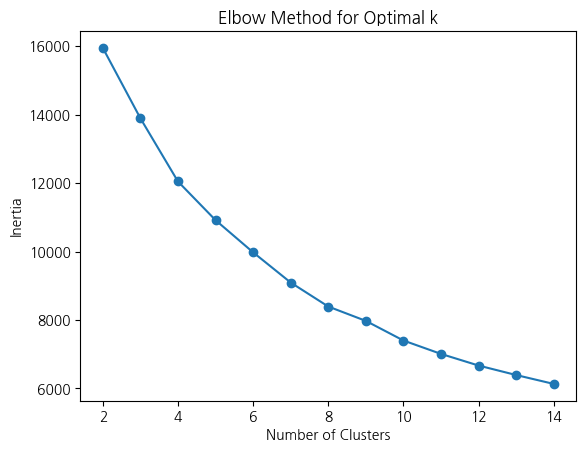

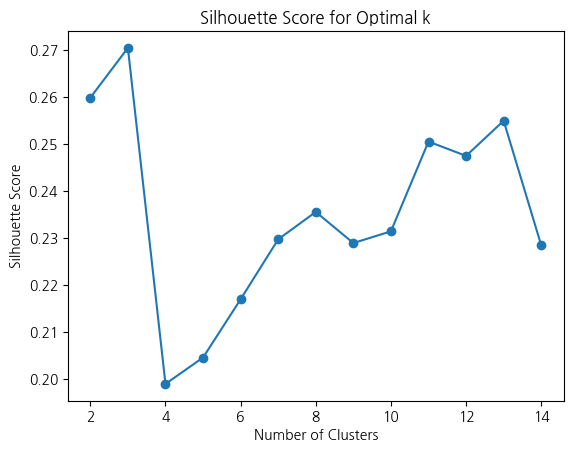

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import cupy as cp  # GPU 배열 라이브러리
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 데이터 불러오기
train_data = pd.read_csv('train.csv')  # 학습 데이터
test_data = pd.read_csv('test.csv')    # 테스트 데이터

# 범주형 데이터 인코딩 (학습 데이터)
one_hot_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # One-Hot Encoding 대상 컬럼

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train_data[one_hot_cols]).toarray()
train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=train_data.index)
train_data = pd.concat([train_data.drop(columns=one_hot_cols), train_encoded_df], axis=1)

test_encoded = one_hot_encoder.transform(test_data[one_hot_cols]).toarray()
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test_data.index)
test_data = pd.concat([test_data.drop(columns=one_hot_cols), test_encoded_df], axis=1)

# 날짜 데이터 처리 (학습 데이터)
train_data['게재일'] = pd.to_datetime(train_data['게재일'])
train_data['게재연도'] = train_data['게재일'].dt.year
train_data['게재월'] = train_data['게재일'].dt.month
train_data['게재일자'] = train_data['게재일'].dt.day
train_data['게재요일'] = train_data['게재일'].dt.weekday
train_data.drop(columns=['게재일'], inplace=True)


# 피처 엔지니어링 (보증금, 월세, 관리비를 활용한 새로운 특성 생성)
train_data['월세_비율'] = train_data['월세'] / train_data['보증금']
train_data['관리비_비율'] = train_data['관리비'] / train_data['보증금']
train_data['층_비율'] = train_data['해당층'] / train_data['총층']

train_data['관리비_구간'] = '0' # 관리비가 0인 경우, 범주 '0'으로 설정
train_data.loc[train_data['관리비'] > 0, '관리비_구간'] = pd.cut(
    train_data.loc[train_data['관리비'] > 0, '관리비'],
    bins=[0, 5, 10, 15, 20, 30, 100],  # 구간 경계값 지정
    labels=['1', '2', '3', '4', '5', '6'],  # 구간 레이블
    right=False
)
train_data['보증금_로그'] = np.log1p(train_data['보증금'])

test_data['게재일'] = pd.to_datetime(test_data['게재일'])
test_data['게재연도'] = test_data['게재일'].dt.year
test_data['게재월'] = test_data['게재일'].dt.month
test_data['게재일자'] = test_data['게재일'].dt.day
test_data['게재요일'] = test_data['게재일'].dt.weekday
test_data.drop(columns=['게재일'], inplace=True)

test_data['월세_비율'] = test_data['월세'] / test_data['보증금']
test_data['관리비_비율'] = test_data['관리비'] / test_data['보증금']
test_data['층_비율'] = test_data['해당층'] / test_data['총층']
# 테스트 데이터에 동일한 처리 적용
test_data['관리비_구간'] = '0'
test_data.loc[test_data['관리비'] > 0, '관리비_구간'] = pd.cut(
    test_data.loc[test_data['관리비'] > 0, '관리비'],
    bins=[0, 5, 10, 15, 20, 30, 100],
    labels=['1', '2', '3', '4', '5', '6'],
    right=False
)
test_data['보증금_로그'] = np.log1p(test_data['보증금'])

# 수치형 데이터만 선택하여 클러스터링 기반 특성 생성
numeric_columns = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']  # , '관리비'
numeric_df = train_data[numeric_columns].fillna(0)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# 엘보우 기법을 사용한 최적 클러스터 수 탐색
inertia_list = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# 엘보우 기법 시각화
plt.plot(k_range, inertia_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 실루엣 점수 시각화
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

### 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [24]:
print(train.columns)

Index(['ID', '매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
       '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부'],
      dtype='object')


In [25]:
df = pd.DataFrame(train)
nan_columns = df.columns[df.isna().any()].tolist()
print(nan_columns)

['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']


In [26]:
train['중개사무소'].nunique()

279

In [27]:
print('row 개수 :', train.shape[0])

row 개수 : 2452


In [28]:
train.head(30)

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1
5,TRAIN_0005,전화확인,153000000.0,530000,29.50,NaN,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0
6,TRAIN_0006,현장확인,348500000.0,400000,NaN,2.0,3.0,북동향,1.0,1.0,불가능,NaN,0,A72Mx9C8U2,D플랫폼,2024-08-23,0
7,TRAIN_0007,현장확인,139500000.0,590000,NaN,2.0,3.0,동향,2.0,1.0,불가능,NaN,0,d22DX4Y4P8,B플랫폼,2025-03-03,0
8,TRAIN_0008,현장확인,120500000.0,440000,31.55,1.0,2.0,북향,2.0,2.0,가능,18.0,3,G52Iz8V2B9,B플랫폼,2024-05-23,0
9,TRAIN_0009,현장확인,79500000.0,260000,39.66,2.0,3.0,남동향,2.0,1.0,불가능,2.0,0,M90Ph8W9V3,B플랫폼,2024-11-30,0


/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 54728 (\N{HANGUL SYLLABLE HEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_652964/1637874730.py:22: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  

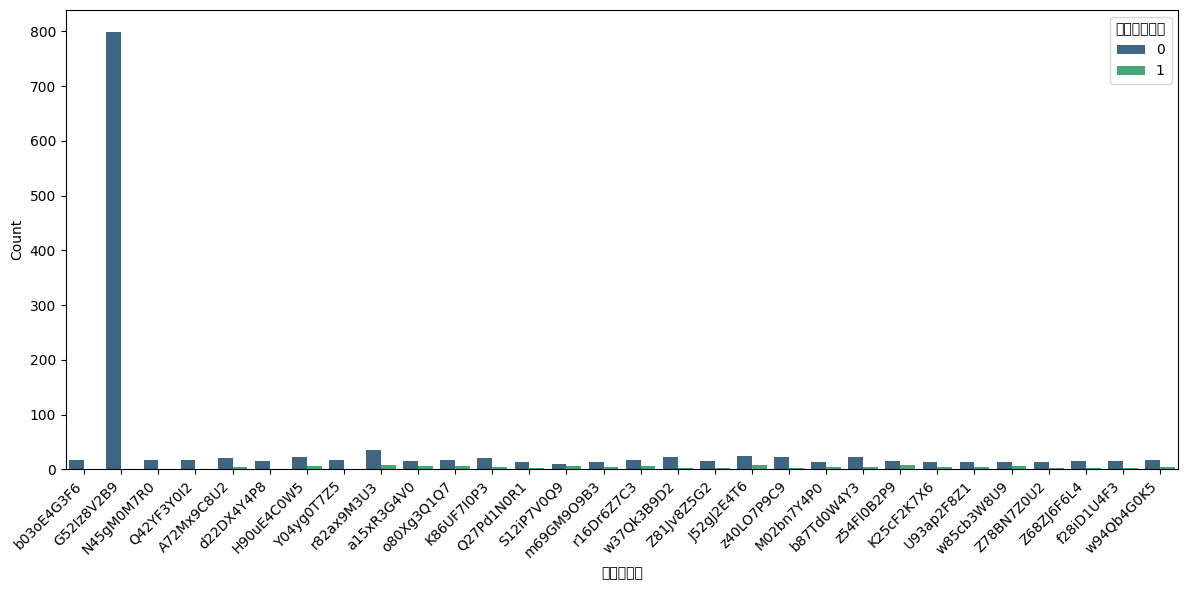

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    '중개사무소': train['중개사무소'],
    '허위매물여부': train['허위매물여부']
}

df = pd.DataFrame(data)

# 허위 매물 수가 많은 상위 20개 중개사무소 선택
top_agents = df['중개사무소'].value_counts().nlargest(30).index
filtered_df = df[df['중개사무소'].isin(top_agents)]

plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='중개사무소', hue='허위매물여부', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('중개사무소')
plt.ylabel('Count')
plt.legend(title='허위매물여부', loc='upper right')
plt.tight_layout()
plt.show()


In [30]:
global_mean = train['허위매물여부'].mean()  # np.float64(0.12153344208809136)

agent_stats = train.groupby('중개사무소')['허위매물여부'].agg(['mean', 'count'])
agent_stats.columns = ['허위매물비율', '매물수']

# 스무딩 계수 설정 (α는 조정 파라미터, 값이 클수록 전체 평균에 더 가까워짐)
alpha = 10
agent_stats['스무딩허위매물비율'] = (agent_stats['허위매물비율'] * agent_stats['매물수'] + global_mean * alpha) / (agent_stats['매물수'] + alpha)

# 원본 데이터에 스무딩된 허위매물 비율 추가
train['중개사무소_스무딩허위매물비율'] = train['중개사무소'].map(agent_stats['스무딩허위매물비율'])
test['중개사무소_스무딩허위매물비율'] = test['중개사무소'].map(agent_stats['스무딩허위매물비율'])

In [16]:
count = 0   # 허위매물298개  / 2452개
for i in train['허위매물여부']:
    if i == 1:
        count+=1
        
print(count)

print(train['허위매물여부'])    

298
0       0
1       0
2       0
3       0
4       1
       ..
2447    0
2448    0
2449    0
2450    0
2451    0
Name: 허위매물여부, Length: 2452, dtype: int64


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [5]:
train['욕실수'].value_counts()

욕실수
1.0    2350
2.0      84
Name: count, dtype: int64

### 데이터 전처리

In [6]:
x = train.drop(['ID','허위매물여부'],axis=1)
y = train['허위매물여부']

In [7]:
# SimpleImputer : 평균 대체
mean_imputer = SimpleImputer(strategy='mean')

# 결측값을 평균으로 대체할 열 목록
columns_fill_mean = ['해당층', '총층','전용면적','방수', '욕실수','총주차대수']

# 학습 데이터에 fit 및 transform
x[columns_fill_mean] = mean_imputer.fit_transform(x[columns_fill_mean])

In [8]:
# Label Encoding 적용 열
label_encode_cols = ['중개사무소','게재일','제공플랫폼','방향']

label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))
    label_encoders[col] = le

In [9]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-Hot Encoding 적용 열
one_hot_cols = ['매물확인방식', '주차가능여부']

# One-Hot Encoding 적용
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Train 데이터 변환
x_encoded = one_hot_encoder.fit_transform(x[one_hot_cols])
x_encoded_df = pd.DataFrame(x_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x.index)

# 기존 데이터와 병합
x = pd.concat([x.drop(columns=one_hot_cols), x_encoded_df], axis=1)

### 학습하기

In [21]:
n_estimators_list = [10, 50, 100, 200, 500]

accuracies = []

# 각 n_estimators 값에 대해 모델 학습 및 성능 평가
for n in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=None, random_state=40)
    # 교차 검증을 통해 성능 평가
    scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')  # 5-fold 교차 검증
    accuracies.append(scores.mean())
    print(f"n_estimators={n}, Mean Accuracy={scores.mean():.4f}, Std={scores.std():.4f}")
    
best_index = np.argmax(accuracies)
best_n_estimators = n_estimators_list[best_index]
best_accuracy = accuracies[best_index]

n_estimators=10, Mean Accuracy=0.9445, Std=0.0137
n_estimators=50, Mean Accuracy=0.9527, Std=0.0104
n_estimators=100, Mean Accuracy=0.9543, Std=0.0076
n_estimators=200, Mean Accuracy=0.9527, Std=0.0045
n_estimators=500, Mean Accuracy=0.9551, Std=0.0062


In [22]:
model = RandomForestClassifier(n_estimators=n_estimators_list[best_index])
model.fit(x,y)

RandomForestClassifier(n_estimators=500)

In [23]:
# model = RandomForestClassifier(n_estimators=100,
#                                criterion='gini',
#                                max_depth=None,
#                                random_state=42)
# model.fit(x, y)

### 예측하기

In [26]:
# Test 데이터 로드
test = pd.read_csv('./test.csv')

# Test 결측값 대체
test[columns_fill_mean] = mean_imputer.transform(test[columns_fill_mean])

# Label Encoding
for col in label_encode_cols:
    if col in test.columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)
        unseen = set(test[col].unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.append(le.classes_, list(unseen))
        test[col] = le.transform(test[col])
        
# One-Hot Encoding
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test.index)

test = pd.concat([test.drop(columns=one_hot_cols), test_encoded_df], axis=1)

test.drop(columns=['ID'],inplace=True)

pred = pd.Series(model.predict(test))

### 제출하기

In [27]:
submit = pd.read_csv('./sample_submission.csv')
submit['허위매물여부'] = pred
submit.head()
submit.to_csv('./baseline_submission.csv',index=False)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 데이터 불러오기
train_data = pd.read_csv('train.csv')  # 학습 데이터
test_data = pd.read_csv('test.csv')    # 테스트 데이터

# 결측값 처리 (학습 데이터)
mean_imputer = SimpleImputer(strategy='mean')
columns_fill_mean = ['전용면적', '해당층', '총주차대수']  # 결측값을 평균으로 대체할 컬럼
train_data[columns_fill_mean] = mean_imputer.fit_transform(train_data[columns_fill_mean])

# 범주형 데이터 인코딩 (학습 데이터)
label_encode_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # Label Encoding 대상 컬럼
one_hot_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # One-Hot Encoding 대상 컬럼

# Label Encoding
label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    label_encoders[col] = le

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')  # sparse=False 제거
train_encoded = one_hot_encoder.fit_transform(train_data[one_hot_cols]).toarray()  # .toarray() 추가
train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=train_data.index)
train_data = pd.concat([train_data.drop(columns=one_hot_cols), train_encoded_df], axis=1)

# 날짜 데이터 처리 (학습 데이터)
train_data['게재일'] = pd.to_datetime(train_data['게재일'])
train_data['게재연도'] = train_data['게재일'].dt.year
train_data['게재월'] = train_data['게재일'].dt.month
train_data['게재일자'] = train_data['게재일'].dt.day
train_data['게재요일'] = train_data['게재일'].dt.weekday
train_data.drop(columns=['게재일'], inplace=True)

# 특성과 레이블 분리 (학습 데이터)
X = train_data.drop(columns=['ID', '허위매물여부'])
y = train_data['허위매물여부']

# 데이터 분할 (학습 데이터와 검증 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 학습 데이터 성능 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 테스트 데이터 전처리
# 결측값 처리 (테스트 데이터)
test_data[columns_fill_mean] = mean_imputer.transform(test_data[columns_fill_mean])

# Label Encoding (테스트 데이터)
for col in label_encode_cols:
    if col in test_data.columns:
        le = label_encoders[col]
        test_data[col] = test_data[col].astype(str)
        unseen = set(test_data[col].unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.append(le.classes_, list(unseen))
        test_data[col] = le.transform(test_data[col])

# One-Hot Encoding (테스트 데이터)
test_encoded = one_hot_encoder.transform(test_data[one_hot_cols]).toarray()  # .toarray() 추가
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test_data.index)
test_data = pd.concat([test_data.drop(columns=one_hot_cols), test_encoded_df], axis=1)

# 날짜 데이터 처리 (테스트 데이터)
test_data['게재일'] = pd.to_datetime(test_data['게재일'])
test_data['게재연도'] = test_data['게재일'].dt.year
test_data['게재월'] = test_data['게재일'].dt.month
test_data['게재일자'] = test_data['게재일'].dt.day
test_data['게재요일'] = test_data['게재일'].dt.weekday
test_data.drop(columns=['게재일'], inplace=True)

# ID 컬럼 제거 (테스트 데이터)
test_data.drop(columns=['ID'], inplace=True)

# 테스트 데이터 예측
pred = pd.Series(model.predict(test_data))

# 예측 결과 출력
print(pred)

Accuracy: 0.8961303462321792
Confusion Matrix:
 [[423   5]
 [ 46  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       428
           1       0.77      0.27      0.40        63

    accuracy                           0.90       491
   macro avg       0.84      0.63      0.67       491
weighted avg       0.89      0.90      0.87       491

0      0
1      0
2      0
3      0
4      0
      ..
608    0
609    0
610    0
611    0
612    0
Length: 613, dtype: int64


In [32]:
submit = pd.read_csv('./sample_submission.csv')
submit['허위매물여부'] = pred
submit.head()
submit.to_csv('./baseline_submission.csv',index=False)

In [1]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [2]:
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

array([0.4, 0.6])

In [3]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [4]:
np.argmax(p)

0

In [1]:
'''
MajorVoteClassifier class implementation
'''

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key : value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights
    # self.predict 메서드에서 np.argmax를 호출할 때
    # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder 사용.
    def fit(self, X, y):    # 분류기를 설계.
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote는 'probability' "
                             f"또는 'classlabel'이어야 합니다."
                             f"; (vote={self.vote})가 입력되었습니다.")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'분류기와 가중치의 개수는 같아야 합니다.'
                             f'; 가중치 {len(self.weights)} 개,'
                             f' 분류기 {len(self.classifiers)} 개')

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self. classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):   # 다수결 투표로 예측한다.
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:   # 'classlabel' 투표
            # clf.predict 메서드를 사용해서 결과모으기.
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights), axis=1, arr=predictions))
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X): # 분류기의 예측 확률을 평균하여 반환환
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_probas = np.average(probas, axis=0, weights=self.weights)
        return avg_probas
    
    def get_params(self, deep=True):    # 하이퍼파라미터를 반환.
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10 교차검층 : \n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC : {scores.mean():.2f}'
          f'(+/- {scores.std():.2f}) [{label}]')

10 교차검층 : 

ROC AUC : 0.92(+/- 0.15) [Logistic regression]
ROC AUC : 0.87(+/- 0.18) [Decision tree]
ROC AUC : 0.85(+/- 0.13) [KNN]


In [4]:
mv_clf = MajorVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f}'
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92(+/- 0.15) [Logistic regression]
ROC AUC: 0.87(+/- 0.18) [Decision tree]
ROC AUC: 0.85(+/- 0.13) [KNN]
ROC AUC: nan(+/- nan) [Majority voting]


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: MajorVoteClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

  warnings.warn(
/opt/con

In [7]:
import lightgbm as lgb
print(lgb.basic._LIB.LGBM_GetLastError())

b'Everything is fine'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from tqdm import tqdm

# 데이터 불러오기
train_data = pd.read_csv('train.csv')  # 학습 데이터
test_data = pd.read_csv('test.csv')    # 테스트 데이터

# KNN으로 결측치를 대체할 컬럼
columns_fill_knn = ['전용면적', '해당층', '총주차대수']

# 범주형 데이터 인코딩 (학습 데이터)
label_encode_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # Label Encoding 대상 컬럼
one_hot_cols = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']  # One-Hot Encoding 대상 컬럼

# Label Encoding
label_encoders = {}
for col in tqdm(label_encode_cols, desc="Label Encoding"):
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    label_encoders[col] = le
    
    
print(label_encoders)

Label Encoding: 100%|██████████| 5/5 [00:00<00:00, 1352.48it/s]

{'매물확인방식': LabelEncoder(), '방향': LabelEncoder(), '주차가능여부': LabelEncoder(), '중개사무소': LabelEncoder(), '제공플랫폼': LabelEncoder()}


In [2]:
for col, le in label_encoders.items():
    print(f"Column: {col}")
    print(f"Classes: {le.classes_}")  # 범주(categories)
    print(f"Encoded Values: {np.arange(len(le.classes_))}")  # 정수 인코딩 값
    print()

Column: 매물확인방식
Classes: ['서류확인' '전화확인' '현장확인']
Encoded Values: [0 1 2]

Column: 방향
Classes: ['남동향' '남서향' '남향' '동향' '북동향' '북서향' '북향' '서향']
Encoded Values: [0 1 2 3 4 5 6 7]

Column: 주차가능여부
Classes: ['가능' '불가능']
Encoded Values: [0 1]

Column: 중개사무소
Classes: ['A06Nz2Z1R1' 'A18IU3D9M4' 'A21Yr4B1U8' 'A24sf9I9O0' 'A40fe5W3A7'
 'A67he0U8R6' 'A72Mx9C8U2' 'B14iW9I2Y0' 'B15GU1Y1M2' 'B44YF9W3O5'
 'B91Ts7P1Z7' 'C10hv5Y7M9' 'C41wx1K6U9' 'C74MD6S8M9' 'C91Rb1A9J3'
 'D23Tf3O2W0' 'D24eh4J3C3' 'D25dP0R4Q9' 'D26uW0Q2N3' 'D30QB7N3P2'
 'D47oH9N4M3' 'D49QC8I7L2' 'D60hO0T7H3' 'E29LO2X8S7' 'E29tC1X2E8'
 'E50oI2O1J6' 'E65ar6O9X7' 'E74qO9X4W9' 'F49jl7E7S8' 'F75Eb9Q3L0'
 'G38pb6B9C7' 'G52Iz8V2B9' 'G56AC9J0D6' 'G71dR3J6C2' 'G80cC8L0A4'
 'G85Og3G9E9' 'G95MY2L8J8' 'H24Fm1I5F3' 'H27VL2C4C3' 'H48dV2F8M5'
 'H58ZK7F1X4' 'H90uE4C0W5' 'I07Ly5R0J1' 'I81Xq1F6S7' 'I91PA2M6T3'
 'I97SP1K4K9' 'J00Mu6V1D3' 'J07Zn4B0R7' 'J19lz3U6S5' 'J30yG7F1O0'
 'J34zf6Z7T0' 'J52gJ2E4T6' 'J60uM1S7H0' 'J99uP8I8G0' 'K25cF2K7X6'
 'K38kY2R6G0' 'K48

In [19]:
# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train_data[one_hot_cols]).toarray()
train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=train_data.index)
train_data = pd.concat([train_data.drop(columns=one_hot_cols), train_encoded_df], axis=1)

In [21]:
print(train_encoded_df)

      매물확인방식_0  매물확인방식_1  매물확인방식_2  방향_0  방향_1  방향_2  방향_3  방향_4  방향_5  방향_6  \
0          0.0       0.0       1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1          0.0       0.0       1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
2          0.0       1.0       0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
3          0.0       0.0       1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0       0.0       1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
...        ...       ...       ...   ...   ...   ...   ...   ...   ...   ...   
2447       1.0       0.0       0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
2448       1.0       0.0       0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
2449       0.0       1.0       0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
2450       0.0       0.0       1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
2451       0.0       1.0       0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

      ...  제공플랫폼_3  제공플랫폼_4  제공플랫폼_5  제

In [10]:
# 날짜 데이터 처리 (학습 데이터)
train_data['게재일'] = pd.to_datetime(train_data['게재일'])
train_data['게재연도'] = train_data['게재일'].dt.year
train_data['게재월'] = train_data['게재일'].dt.month
train_data['게재일자'] = train_data['게재일'].dt.day
train_data['게재요일'] = train_data['게재일'].dt.weekday
train_data.drop(columns=['게재일'], inplace=True)

In [11]:
print(train_data)

              ID          보증금      월세   전용면적  해당층    총층   방수  욕실수  총주차대수  관리비  \
0     TRAIN_0000  402500000.0  470000    NaN  NaN  15.0  1.0  1.0   40.0   96   
1     TRAIN_0001  170500000.0  200000    NaN  3.0   4.0  2.0  1.0    NaN    0   
2     TRAIN_0002  114000000.0  380000    NaN  2.0   3.0  1.0  1.0    NaN    0   
3     TRAIN_0003  163500000.0   30000  36.30  3.0   9.0  2.0  1.0   13.0   10   
4     TRAIN_0004  346000000.0  530000    NaN  3.0   3.0  2.0  1.0    NaN    0   
...          ...          ...     ...    ...  ...   ...  ...  ...    ...  ...   
2447  TRAIN_2447  159000000.0  550000  48.95  3.0   3.0  2.0  1.0    NaN    0   
2448  TRAIN_2448  158500000.0  750000    NaN  2.0   4.0  1.0  1.0    NaN    2   
2449  TRAIN_2449  329000000.0  610000  17.50  8.0  20.0  1.0  1.0   29.0   10   
2450  TRAIN_2450   31000000.0  400000  22.87  8.0   9.0  2.0  1.0    NaN    8   
2451  TRAIN_2451  126000000.0  340000  29.89  4.0   6.0  2.0  1.0    8.0    7   

      ...  제공플랫폼_7  제공플랫폼_8

In [12]:
# 특성과 레이블 분리 (학습 데이터)
X = train_data.drop(columns=['ID', '허위매물여부'])
y = train_data['허위매물여부']

In [14]:
print(y)

0       0
1       0
2       0
3       0
4       1
       ..
2447    0
2448    0
2449    0
2450    0
2451    0
Name: 허위매물여부, Length: 2452, dtype: int64
